# The Flow Generator of Directed Graphs

In [ ]:
#| default_exp generator
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import torch
import torch_geometric
%load_ext autoreload
%autoreload 2

FEARFRED is built of three intertwingled components, two standard for a GAN, and one unique to its graph-embedding mission:
1. The Generator - creates and samples from a flow field, intended to model the directed graph
2. The Random Walkers - given a sample from the flow field, constructs a directed *sub*-graph with a gaggle of random walkers.
3. The GNN discriminator - given a directeed (sub)graph, classifies it as belonging to the ground truth data.

This notebook defines and tests the Flow Generator.

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
class FlowGenerator(nn.Module):
    def __init__(
        self,
        dimension, # intrinsic dimension of the data manifold. Should be estimated prior to applying FEARFRED
        n_features, # features per node
    ):
        self.dimension = dimension
        self.n_features = n_features
        super().__init__()
        # the flow artist creates the vector field
        self.flow_artist_l1 = nn.Linear(self.dimension, 64)
        self.flow_artist_l2 = nn.Linear(64, 64)
        self.flow_artist_l3 = nn.Linear(64, 64)
        self.flow_artist_l4 = nn.Linear(64, 64)
        self.flow_artist_l5 = nn.Linear(64, 64)
        self.flow_artist_l6 = nn.Linear(64, 64)
        self.flow_artist_l7 = nn.Linear(64, 64)
        self.flow_artist_l8 = nn.Linear(64, self.dimension)
        # the flow sampler defines a distribution over the vector field, showing where in the space to sample from
        self.flow_sampler_l1 = nn.Linear(self.dimension, 64)
        self.flow_sampler_l2 = nn.Linear(64, 64)
        self.flow_sampler_l3 = nn.Linear(64, 64)
        self.flow_sampler_l4 = nn.Linear(64, 64)
        self.flow_sampler_l5 = nn.Linear(64, 64)
        self.flow_sampler_l6 = nn.Linear(64, 64)
        self.flow_sampler_l7 = nn.Linear(64, 64)
        self.flow_sampler_l8 = nn.Linear(64, self.dimension)
        # the feature giver assigns features to each point in the embedding space
        self.feature_giver_l1 = nn.Linear(self.dimension, 64)
        self.feature_giver_l2 = nn.Linear(64, 64)
        self.feature_giver_l3 = nn.Linear(64, 64)
        self.feature_giver_l4 = nn.Linear(64, 64)
        self.feature_giver_l5 = nn.Linear(64, 64)
        self.feature_giver_l6 = nn.Linear(64, 64)
        self.feature_giver_l7 = nn.Linear(64, 64)
        self.feature_giver_l8 = nn.Linear(64, self.n_features)
    def flow_artist(self,x):
        # evaluates the vector field at point x
        x = self.flow_artist_l1(x)
        x = F.gelu(x)
        x = self.flow_artist_l2(x)
        x = F.gelu(x)
        x = self.flow_artist_l3(x)
        x = F.gelu(x)
        x = self.flow_artist_l4(x)
        x = F.gelu(x)
        x = self.flow_artist_l5(x)
        x = F.gelu(x)
        x = self.flow_artist_l6(x)
        x = F.gelu(x)
        x = self.flow_artist_l7(x)
        x = F.gelu(x)
        x = self.flow_artist_l8(x)
        return x
    def flow_sampler(self,x):
        # samples from the embedding space. Should be given inputs in [0,1]^n
        x = self.flow_sampler_l1(x)
        x = F.gelu(x)
        x = self.flow_sampler_l2(x)
        x = F.gelu(x)
        x = self.flow_sampler_l3(x)
        x = F.gelu(x)
        x = self.flow_sampler_l4(x)
        x = F.gelu(x)
        x = self.flow_sampler_l5(x)
        x = F.gelu(x)
        x = self.flow_sampler_l6(x)
        x = F.gelu(x)
        x = self.flow_sampler_l7(x)
        x = F.gelu(x)
        x = self.flow_sampler_l8(x)
        return x
    def feature_giver(self,x):
        # samples from the embedding space. Should be given inputs in [0,1]^n
        x = self.feature_giver_l1(x)
        x = F.gelu(x)
        x = self.feature_giver_l2(x)
        x = F.gelu(x)
        x = self.feature_giver_l3(x)
        x = F.gelu(x)
        x = self.feature_giver_l4(x)
        x = F.gelu(x)
        x = self.feature_giver_l5(x)
        x = F.gelu(x)
        x = self.feature_giver_l6(x)
        x = F.gelu(x)
        x = self.feature_giver_l7(x)
        x = F.gelu(x)
        x = self.feature_giver_l8(x)
        return x
    def forward(self,samples):
        points = self.flow_sampler(samples)
        flows = self.flow_artist(points)
        features = self.feature_giver(points)
        return points,flows,features
        

## Visualizing the output

In [ ]:
# testing to ensure it runs
FG = FlowGenerator(dimension=2, n_features=1)
points = FG.flow_sampler(torch.rand(50,2))
flows = FG.flow_artist(points)

In [ ]:
#| export
from FEARFRED.plotting import plot_directed_2d, plot_flow_field_2d

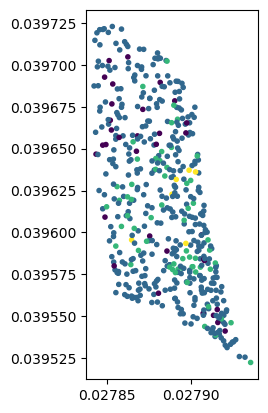

In [ ]:
plot_flow_field_2d(FG)

# Testing

To examine the generative power of the `FlowGenerator`, here's a couple of simple tests, where we instruct it to recreate toy manifolds based on a direct penalty. Each will recieve points and associated flows and penalize them for adherence to a toy manifold.

## Can it learn a circle?

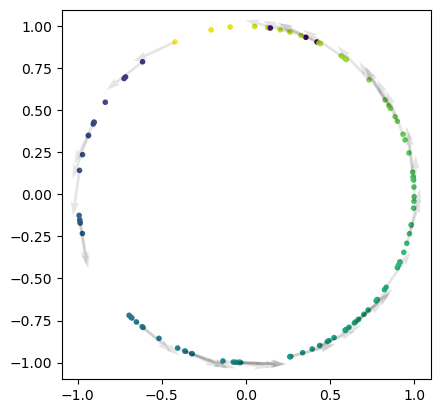

In [ ]:
random_samples = torch.rand(100,2)*2-1
angles_of_samples = torch.norm(random_samples,dim=1)*2*torch.pi
real_circle, real_flows = torch.zeros_like(random_samples), torch.zeros_like(random_samples)
real_circle[:,0] = torch.cos(angles_of_samples)
real_circle[:,1] = torch.sin(angles_of_samples)
real_flows[:,0] = -torch.sin(angles_of_samples)
real_flows[:,1] = torch.cos(angles_of_samples)
plot_directed_2d(real_circle,real_flows,angles_of_samples)

In [ ]:
def circle_loss(points, flows, features, random_samples):
    loss = 0
    # calculate angles of points 
    angles_of_samples = torch.norm(random_samples,dim=1)*2*torch.pi
    real_circle, real_flows = torch.zeros_like(random_samples), torch.zeros_like(random_samples)
    real_circle[:,0] = torch.cos(angles_of_samples)
    real_circle[:,1] = torch.sin(angles_of_samples)
    real_flows[:,0] = -torch.sin(angles_of_samples)
    real_flows[:,1] = torch.cos(angles_of_samples)
    # penalize all of the points to have distance 1 from the origin
    loss += torch.linalg.norm(points - real_circle)
    # penalize flows to be perpendicular to the points, i.e. have zero cosine similarity
    loss += torch.sum(1-torch.abs(F.cosine_similarity(flows,real_flows)))
    # penalize features to be the angles
    loss += 0.01*torch.linalg.norm(features - angles_of_samples)
    return loss

  0%|          | 0/2000 [00:00<?, ?it/s]

[<matplotlib.lines.Line2D>]

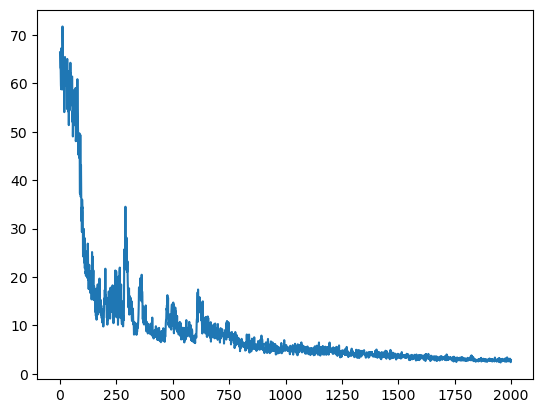

In [ ]:
model = FlowGenerator(dimension=2,n_features=1)
device = torch.device('cpu')
model.to(device)
opt = torch.optim.Adam(model.parameters()) 
train_accs, test_accs, losses = [], [], [] # lists to keep track of model stats
for e in trange(2000): # this is the number of epochs to train -- each epoch iterates through the entire dataset.
    model.train()
    samples = torch.rand(128,2)
    points, flows, features = model(samples)    
    l = circle_loss(points,flows,features, samples)
    l.backward()
    opt.step()
    opt.zero_grad()
    losses.append(l.item())
plt.plot(losses)

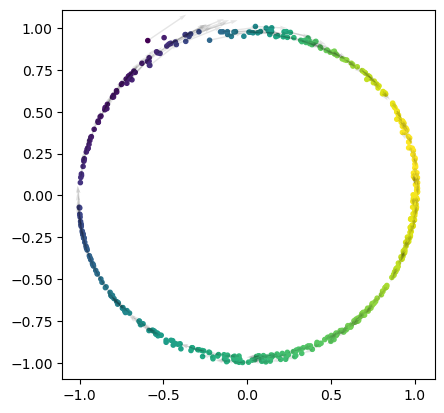

In [ ]:
plot_flow_field_2d(model)

# Results

Yes, the generator can successfully learn the flow field and sampling strategy of a circle. Using 8 layers instead of 3 helped it learn with 10x less training.